#Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtp
from math import*
import copy
from graphviz import Digraph
import random

#Available Datasets


---


1.   Tennis
2.   [Cars](https://archive.ics.uci.edu/ml/datasets/car+evaluation)
3.   [Lenses](https://archive.ics.uci.edu/ml/datasets/lenses)
4.   [Chess](https://archive.ics.uci.edu/ml/datasets/Chess+%28King-Rook+vs.+King-Pawn%29)
5.   [Baloons](https://archive.ics.uci.edu/ml/datasets/Balloons)
6.   [Lymphography](https://archive.ics.uci.edu/ml/datasets/Lymphography)
7.   [Heart](https://archive.ics.uci.edu/ml/datasets/SPECT+Heart)




In [26]:
datasets={'tennis':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/data.csv','PlayTennis'],'cars':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/car.csv','class'],'lenses':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/lenses.csv','Class'],'chess':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/kr-vs-kp.csv','result'],'baloons':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/balloons.csv','inflated'],'lymphography':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/lymphography.csv','no. of nodes in'],'heart':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/SPECT.csv','diagnosis']}

#Implementation of Train Test Split Function

In [27]:
def train_test_split(df,test_size):
  df=df.sample(frac = 1)
  n=len(df)
  no_test_rows=int(n*test_size)
  l=list(random.sample(list(range(n)), no_test_rows))
  test=df.iloc[l]
  train=df.drop(l,axis=0)
  return train.sample(frac = 1),test.sample(frac = 1)

#Implementation of Accuracy Function 

In [28]:
def accuracy_score(y_true, y_pred):
  total_count=len(y_true)
  correct_prediction_count=0
  for i in range(total_count):
    if y_true[i]==y_pred[i]:
      correct_prediction_count+=1
  return (correct_prediction_count/total_count)*100

#Implementation of Decision Tree Algorithm

In [29]:
class DecisionTree():
  
  ## Class Member Functions ##

  def entropy_help(p):
    return -p*log(p,2)
  
  def getEntropy(df,target_name):  
    n=df.count()[0]
    target_counts=df[target_name].value_counts().to_dict()
    s=0
    for p in target_counts.values():
      if p/n==1 or p/n==0:
        return 0
      s+=DecisionTree.entropy_help(p/n)
    # print(s)
    return s
  
  def getProbability(df,column,value):
    return df[df[column]==value].count()[0]/df.count()[0]
  
  def informationGain(df,target_name,col):
    # print("Entropy of ",col,DecisionTree.getEntropy(df,target_name))
    total_entropy=DecisionTree.getEntropy(df,target_name)
    col_vals_count=df[col].value_counts().to_dict()
    sum=0
    for value in col_vals_count:
      n=col_vals_count[value]
      # print("Entropy of ",col,value,DecisionTree.getEntropy(df[df[col]==value],target_name))
      sum+=(DecisionTree.getEntropy(df[df[col]==value],target_name)*DecisionTree.getProbability(df,col,value))
    # print("IG: ",target_name,col,total_entropy-sum)
    return total_entropy-sum

  ## Class Data Members ##

  split_functions={'IG':informationGain}
  
  ## Countructor ##
  def __init__(self,df,target_name,split_function="IG",level=-1,leaf_nodes=-1):
    self.tree=self.Tree()
    self.df=df
    self.target_name=target_name
    self.cols=list(self.df.columns)
    self.cols.remove(self.target_name)
    self.cnt=0
    self.gnodes=[]
    self.level=level
    self.leaf_nodes=leaf_nodes
    self.rules=[]
    self.output_classes=self.df[self.target_name].unique()
    if split_function in DecisionTree.split_functions:
      self.split_function=DecisionTree.split_functions[split_function]
    else:
      raise Exception("Split function not found")

  ## Instance Methods ##

  def getGraph(self):
    return self.tree.g

  def find_leaf(self,df):
    counts=df[self.target_name].value_counts().to_dict()
    return max(zip(counts.values(), counts.keys()))[1]
    
      # unique_vals=list(df[self.target_name].unique())
      # for val in unique_vals:      
      #   if df[df[self.target_name]==val].count()[0]==df.count()[0]:
      #     return val

  def construct(self):
    maxig=[-1,""]
    for i in self.cols:
      etemp=self.split_function(df,self.target_name,i)
      maxig=maxig if maxig[0]>etemp else [etemp,i]
    root=self.Node(maxig[1],maxig[0],0)
    self.tree.insert_root(root)
    c=copy.deepcopy(self.cols)
    c.remove(root.name)
    root.gname=str(root)
    self.gnodes.append(root)
    self.tree.g.node(str(root),str(root))
    self.construct_help(df,c,root)

  def construct_help(self,df,cols,parent):
    if not parent.name:
      return
    vals=list(df[parent.name].unique())
    dftemp=df

    for k in vals:
      if self.leaf_nodes!=-1 and self.tree.no_leafs>=self.leaf_nodes:
        return
      df=dftemp
      df=df[df[parent.name]==k]
      e=DecisionTree.getEntropy(df,self.target_name)

      if e==0 or parent.level==self.level-1:
        value=self.find_leaf(df)
        node=self.Node(value,1,parent.level+1)
        node.gname=str(value)
        parent.insert_child(node)
        parent.insert_edge(k)
        self.tree.no_leafs+=1
        name=value
        if not isinstance(value, str):
          name='class'
        self.tree.g.node(name+str(self.cnt),str(value))
        self.tree.g.edge(str(parent.gname),name+str(self.cnt),label=str(k))
        
        self.cnt+=1
        continue
      maxig=[-1,""]
      for i in cols:
        etemp=self.split_function(df,self.target_name,i)
        maxig=maxig if maxig[0]>etemp else [etemp,i]
      node=self.Node(maxig[1],maxig[0],parent.level+1)
      node.gname=str(node.name)
      c=copy.deepcopy(cols)
      if node.name in c:
        c.remove(node.name)
      name=str(node)

      # checking if node name already exist in graphviz code
      
      if name in self.gnodes:
        name+=str(self.cnt)
        self.cnt+=1
      else:
        self.gnodes.append(name)
      node.gname=name

      parent.insert_child(node)
      parent.insert_edge(k)

      self.tree.g.node(name,str(node))
      self.tree.g.edge(str(parent.gname),name,label=str(k))
      
      self.construct_help(df[df[parent.name]==k],c,node)
      
  def predict(self,instances,trace=False):
    node=self.tree.root
    op=[]
    if isinstance(instances,dict):
      return self.predict_help(node,instances,trace,"")
    if isinstance(instances,list):
      
      for instance in instances:
        op.append(self.predict_help(node,instance,trace,""))
    else:
      n=len(instances)
      for i in range(n):
        instance=instances.iloc[i].to_dict()
        op.append(self.predict_help(node,instance,trace,""))
    return op

  def predict_help(self,node,instance,trace,path):
    if node.name in self.output_classes:
      if trace:
        print(path+str(node))
      return node.name
    value=instance[node.name]
    try:
      path+=str(node)+" ( "+str(value)+" ) -> "
      ind=node.edges.index(value)
      return self.predict_help(node.childs[ind],instance,trace,path)
    except Exception as e:
      return "Not valid instance, path: "+path
  def get_rules(self):
    node=self.tree.root
    self.rules_help(node,str(node.name)+" -> ")
    return self.rules

  def rules_help(self,node,path):
    for n,e in zip(node.childs,node.edges):
      if n.name in self.output_classes:
        self.rules.append("{} ( {} ) {}".format(path,str(e),str(n.name)))
      self.rules_help(n,"{} ( {} ) {} -> ".format(path,str(e),str(n.name)))
  
  ## Inner classes ##
  class Node:
    ## Countructor ##
    def __init__(self,name,ig,level):
      self.name=name
      self.ig=ig
      self.childs=[]
      self.edges=[]
      self.gname=''
      self.level=level

    ## Instance Methods ##

    def insert_child(self,node):
      self.childs.append(node)

    def insert_edge(self,edge):
      self.edges.append(edge)

    def printn(self,edge=""):
      # if self.childs:
      dashes="|"+"-"*(self.level*5)
      value="( "+str(edge)+") "+str(self.gname) if edge else str(self.gname)
      # print(" "*(self.level*2+1),''.join(['-']*31))
      # print(dashes,'|{:^15} - level - {:^2} | '.format(self.gname,self.level),list(zip(self.edges,list(map(lambda x:x.gname,self.childs)))))
      # print(" "*(self.level*2+1),''.join(['-']*31))
      print(dashes,value)

    def __str__(self):
      return str(self.name)

  class Tree:

    ## Countructor ##
    def __init__(self):
      self.root=None
      self.g=Digraph(encoding='utf-8')
      self.no_leafs=0

    ## Instance Methods ##

    def insert_root(self,node):
      self.root=node

    def printt(self):
      self.print_help(self.root,"")

    def print_help(self,node,edge):
      if node:
        node.printn(edge)
        # print("(",edge,")")
      for i in range(len(node.childs)):
        self.print_help(node.childs[i],node.edges[i])

#Tennis Dataset

In [30]:
## Variables ##
dataset='tennis'
split_func='IG'

##Reading Datast

In [31]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [32]:
data

,Outlook,Temperature,Humidity,wind,PlayTennis
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes
5,rain,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rain,mild,normal,weak,yes


In [33]:
data.dtypes

Outlook        object
Temperature    object
Humidity       object
wind           object
PlayTennis     object
dtype: object

In [34]:
# test_df=data
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))


# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

Size of Train Dataset:  10 
 Size of Test Dataset:  4


In [35]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

Outlook        10
Temperature    10
Humidity       10
wind           10
PlayTennis     10
dtype: int64
10


##Descion Tree Training

In [36]:
d=DecisionTree(data,target_name,split_function=split_func)

In [37]:
d.construct()

In [38]:
print(d.tree.no_leafs)

5


In [39]:
d.get_rules()

['Outlook ->  ( sunny ) Humidity ->  ( high ) no',
 'Outlook ->  ( sunny ) Humidity ->  ( normal ) yes',
 'Outlook ->  ( overcast ) yes',
 'Outlook ->  ( rain ) wind ->  ( strong ) no',
 'Outlook ->  ( rain ) wind ->  ( weak ) yes']

In [40]:
d.tree.printt()

| Outlook
|----- ( sunny) Humidity
|---------- ( high) no
|---------- ( normal) yes
|----- ( overcast) yes
|----- ( rain) wind
|---------- ( strong) no
|---------- ( weak) yes


##Graphviz Representation of Decision Tree

In [41]:
f = open("Tennis.dot", "w")
f.write(str(d.getGraph()))
f.close()

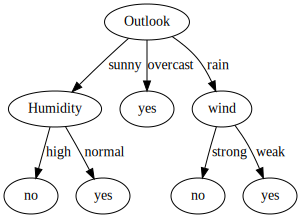

In [42]:
d.getGraph()

##Predicting on Train Dataset

In [43]:
df

,Outlook,Temperature,Humidity,wind,PlayTennis
0,sunny,hot,high,weak,no
2,overcast,hot,high,weak,yes
7,sunny,mild,high,weak,no
11,overcast,mild,high,strong,yes
5,rain,cool,normal,strong,no
8,sunny,cool,normal,weak,yes
12,overcast,hot,normal,weak,yes
9,rain,mild,normal,weak,yes
6,overcast,cool,normal,strong,yes
13,rain,mild,high,strong,no


In [44]:
y_train_pred=d.predict(df)
print(y_train_pred)
print(df[target_name])
print(accuracy_score(df[target_name].tolist(),y_train_pred))

['no', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no']
0      no
2     yes
7      no
11    yes
5      no
8     yes
12    yes
9     yes
6     yes
13     no
Name: PlayTennis, dtype: object
100.0


##Predicting on Test Dataset

In [45]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

100.0

#Cars Dataset

In [46]:
## Variables ##
dataset='cars'
split_func='IG'

##Reading Datast

In [47]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [48]:
data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [49]:
data.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

In [50]:
# test_df=data
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))


# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

Size of Train Dataset:  1210 
 Size of Test Dataset:  518


In [51]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

buying      1210
maint       1210
doors       1210
persons     1210
lug_boot    1210
safety      1210
class       1210
dtype: int64
1210


##Descion Tree Training

In [52]:
d=DecisionTree(data,target_name,split_function=split_func)

In [53]:
d.construct()

In [54]:
print(d.tree.no_leafs)

220


In [55]:
d.get_rules()

['safety ->  ( low ) unacc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( high ) maint ->  ( high ) acc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( high ) maint ->  ( vhigh ) unacc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( high ) maint ->  ( med ) acc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( high ) maint ->  ( low ) acc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( med ) maint ->  ( high ) acc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( med ) maint ->  ( med ) lug_boot ->  ( small ) acc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( med ) maint ->  ( med ) lug_boot ->  ( med ) doors ->  ( 3 ) acc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( med ) maint ->  ( med ) lug_boot ->  ( med ) doors ->  ( 2 ) acc',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( med ) maint ->  ( med ) lug_boot ->  ( med ) doors ->  ( 4 ) vgood',
 'safety ->  ( high ) persons ->  ( 4 ) buying ->  ( med ) maint ->  ( med ) l

In [56]:
d.tree.printt()

| safety
|----- ( low) unacc
|----- ( high) persons
|---------- ( 4) buying
|--------------- ( high) maint
|-------------------- ( high) acc
|-------------------- ( vhigh) unacc
|-------------------- ( med) acc
|-------------------- ( low) acc
|--------------- ( med) maint5
|-------------------- ( high) acc
|-------------------- ( med) lug_boot
|------------------------- ( small) acc
|------------------------- ( med) doors
|------------------------------ ( 3) acc
|------------------------------ ( 2) acc
|------------------------------ ( 4) vgood
|------------------------------ ( 5more) vgood
|------------------------- ( big) vgood
|-------------------- ( low) lug_boot13
|------------------------- ( big) vgood
|------------------------- ( med) doors15
|------------------------------ ( 2) good
|------------------------------ ( 3) good
|------------------------------ ( 5more) vgood
|------------------------------ ( 4) vgood
|------------------------- ( small) good
|-------------------- ( 

##Graphviz Representation of Decision Tree

In [57]:
f = open("Cars.dot", "w")
f.write(str(d.getGraph()))
f.close()

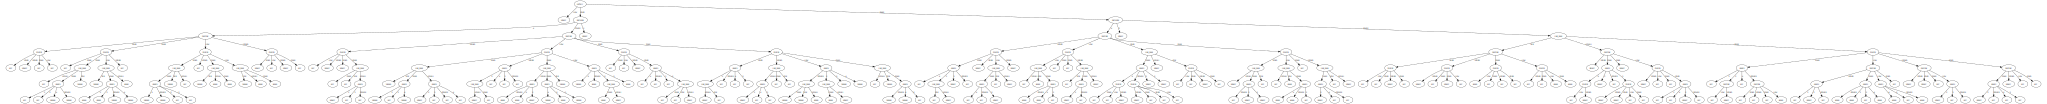

In [58]:
d.getGraph()

##Predicting on Train Dataset

In [59]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


##Predicting on Test Dataset

In [60]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

96.91119691119691

#Lenses Dataset

In [61]:
## Variables ##
dataset='lenses'
split_func='IG'

##Reading Datast

In [62]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [63]:
data

,age,spectacle,astigmatic,tear,Class
0,1,1,1,1,3
1,1,1,1,2,2
2,1,1,2,1,3
3,1,1,2,2,1
4,1,2,1,1,3
5,1,2,1,2,2
6,1,2,2,1,3
7,1,2,2,2,1
8,2,1,1,1,3
9,2,1,1,2,2


In [64]:
data.dtypes

age           int64
spectacle     int64
astigmatic    int64
tear          int64
Class         int64
dtype: object

In [65]:
# test_df=data
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))


# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

Size of Train Dataset:  17 
 Size of Test Dataset:  7


In [66]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

age           17
spectacle     17
astigmatic    17
tear          17
Class         17
dtype: int64
17


##Descion Tree Training

In [67]:
d=DecisionTree(data,target_name,split_function=split_func)

In [68]:
d.construct()

In [69]:
print(d.tree.no_leafs)

7


In [70]:
d.get_rules()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


['tear ->  ( 1 ) 3',
 'tear ->  ( 2 ) astigmatic ->  ( 2 ) spectacle ->  ( 1 ) 1',
 'tear ->  ( 2 ) astigmatic ->  ( 2 ) spectacle ->  ( 2 ) age ->  ( 3 ) 3',
 'tear ->  ( 2 ) astigmatic ->  ( 2 ) spectacle ->  ( 2 ) age ->  ( 1 ) 1',
 'tear ->  ( 2 ) astigmatic ->  ( 2 ) spectacle ->  ( 2 ) age ->  ( 2 ) 3',
 'tear ->  ( 2 ) astigmatic ->  ( 1 ) spectacle ->  ( 2 ) 2',
 'tear ->  ( 2 ) astigmatic ->  ( 1 ) spectacle ->  ( 1 ) 3']

In [71]:
d.tree.printt()

| tear
|----- ( 1) 3
|----- ( 2) astigmatic
|---------- ( 2) spectacle
|--------------- ( 1) 1
|--------------- ( 2) age
|-------------------- ( 3) 3
|-------------------- ( 1) 1
|-------------------- ( 2) 3
|---------- ( 1) spectacle5
|--------------- ( 2) 2
|--------------- ( 1) 3


##Graphviz Representation of Decision Tree

In [72]:
f = open("Lenses.dot", "w")
f.write(str(d.getGraph()))
f.close()

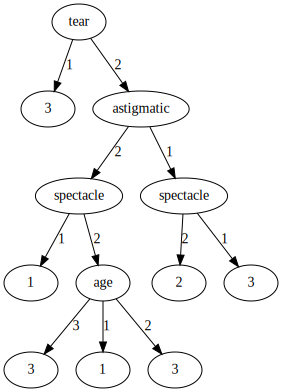

In [73]:
d.getGraph()

##Predicting on Train Dataset

In [74]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


##Predicting on Test Dataset

In [75]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


85.71428571428571

#Chess Dataset

In [76]:
## Variables ##
dataset='chess'
split_func='IG'

##Reading Datast

In [77]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [78]:
data

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,result
0,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,t,f,t,f,f,f,...,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,t,f,...,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,t,f,f,f,f,f,t,f,f,f,...,f,t,f,f,t,f,t,f,n,nowin
3192,t,f,f,f,f,f,t,f,f,f,...,f,t,f,f,t,f,t,f,n,nowin
3193,t,f,f,f,f,f,t,f,f,f,...,f,t,f,f,t,f,t,f,n,nowin
3194,t,f,t,f,f,f,t,f,f,f,...,f,t,f,f,t,f,f,f,n,nowin


In [79]:
data.dtypes

bkblk     object
bknwy     object
bkon8     object
bkona     object
bkspr     object
bkxbq     object
bkxcr     object
bkxwp     object
blxwp     object
bxqsq     object
cntxt     object
dsopp     object
dwipd     object
hdchk     object
katri     object
mulch     object
qxmsq     object
r2ar8     object
reskd     object
reskr     object
rimmx     object
rkxwp     object
rxmsq     object
simpl     object
skach     object
skewr     object
skrxp     object
spcop     object
stlmt     object
thrsk     object
wkcti     object
wkna8     object
wknck     object
wkovl     object
wkpos     object
wtoeg     object
result    object
dtype: object

In [80]:
# test_df=data
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))


# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

Size of Train Dataset:  2238 
 Size of Test Dataset:  958


In [81]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

bkblk     2238
bknwy     2238
bkon8     2238
bkona     2238
bkspr     2238
bkxbq     2238
bkxcr     2238
bkxwp     2238
blxwp     2238
bxqsq     2238
cntxt     2238
dsopp     2238
dwipd     2238
hdchk     2238
katri     2238
mulch     2238
qxmsq     2238
r2ar8     2238
reskd     2238
reskr     2238
rimmx     2238
rkxwp     2238
rxmsq     2238
simpl     2238
skach     2238
skewr     2238
skrxp     2238
spcop     2238
stlmt     2238
thrsk     2238
wkcti     2238
wkna8     2238
wknck     2238
wkovl     2238
wkpos     2238
wtoeg     2238
result    2238
dtype: int64
2238


##Descion Tree Training

In [82]:
d=DecisionTree(data,target_name,split_function=split_func)

In [83]:
d.construct()

In [84]:
print(d.tree.no_leafs)

47


In [85]:
d.get_rules()

['rimmx ->  ( f ) bxqsq ->  ( f ) wknck ->  ( f ) wkpos ->  ( t ) bkxbq ->  ( t ) won',
 'rimmx ->  ( f ) bxqsq ->  ( f ) wknck ->  ( f ) wkpos ->  ( t ) bkxbq ->  ( f ) katri ->  ( n ) rxmsq ->  ( f ) dsopp ->  ( f ) won',
 'rimmx ->  ( f ) bxqsq ->  ( f ) wknck ->  ( f ) wkpos ->  ( t ) bkxbq ->  ( f ) katri ->  ( n ) rxmsq ->  ( f ) dsopp ->  ( t ) dwipd ->  ( g ) thrsk ->  ( f ) skewr ->  ( f ) won',
 'rimmx ->  ( f ) bxqsq ->  ( f ) wknck ->  ( f ) wkpos ->  ( t ) bkxbq ->  ( f ) katri ->  ( n ) rxmsq ->  ( f ) dsopp ->  ( t ) dwipd ->  ( g ) thrsk ->  ( f ) skewr ->  ( t ) wtoeg ->  ( n ) won',
 'rimmx ->  ( f ) bxqsq ->  ( f ) wknck ->  ( f ) wkpos ->  ( t ) bkxbq ->  ( f ) katri ->  ( n ) rxmsq ->  ( f ) dsopp ->  ( t ) dwipd ->  ( g ) thrsk ->  ( f ) skewr ->  ( t ) wtoeg ->  ( t ) nowin',
 'rimmx ->  ( f ) bxqsq ->  ( f ) wknck ->  ( f ) wkpos ->  ( t ) bkxbq ->  ( f ) katri ->  ( n ) rxmsq ->  ( f ) dsopp ->  ( t ) dwipd ->  ( g ) thrsk ->  ( t ) nowin',
 'rimmx ->  ( f ) bx

In [86]:
d.tree.printt()

| rimmx
|----- ( f) bxqsq
|---------- ( f) wknck
|--------------- ( f) wkpos
|-------------------- ( t) bkxbq
|------------------------- ( t) won
|------------------------- ( f) katri
|------------------------------ ( n) rxmsq
|----------------------------------- ( f) dsopp
|---------------------------------------- ( f) won
|---------------------------------------- ( t) dwipd
|--------------------------------------------- ( g) thrsk
|-------------------------------------------------- ( f) skewr
|------------------------------------------------------- ( f) won
|------------------------------------------------------- ( t) wtoeg
|------------------------------------------------------------ ( n) won
|------------------------------------------------------------ ( t) nowin
|-------------------------------------------------- ( t) nowin
|--------------------------------------------- ( l) won
|----------------------------------- ( t) qxmsq
|---------------------------------------- ( t) won
|---

##Graphviz Representation of Decision Tree

In [87]:
f = open("Chess.dot", "w")
f.write(str(d.getGraph()))
f.close()

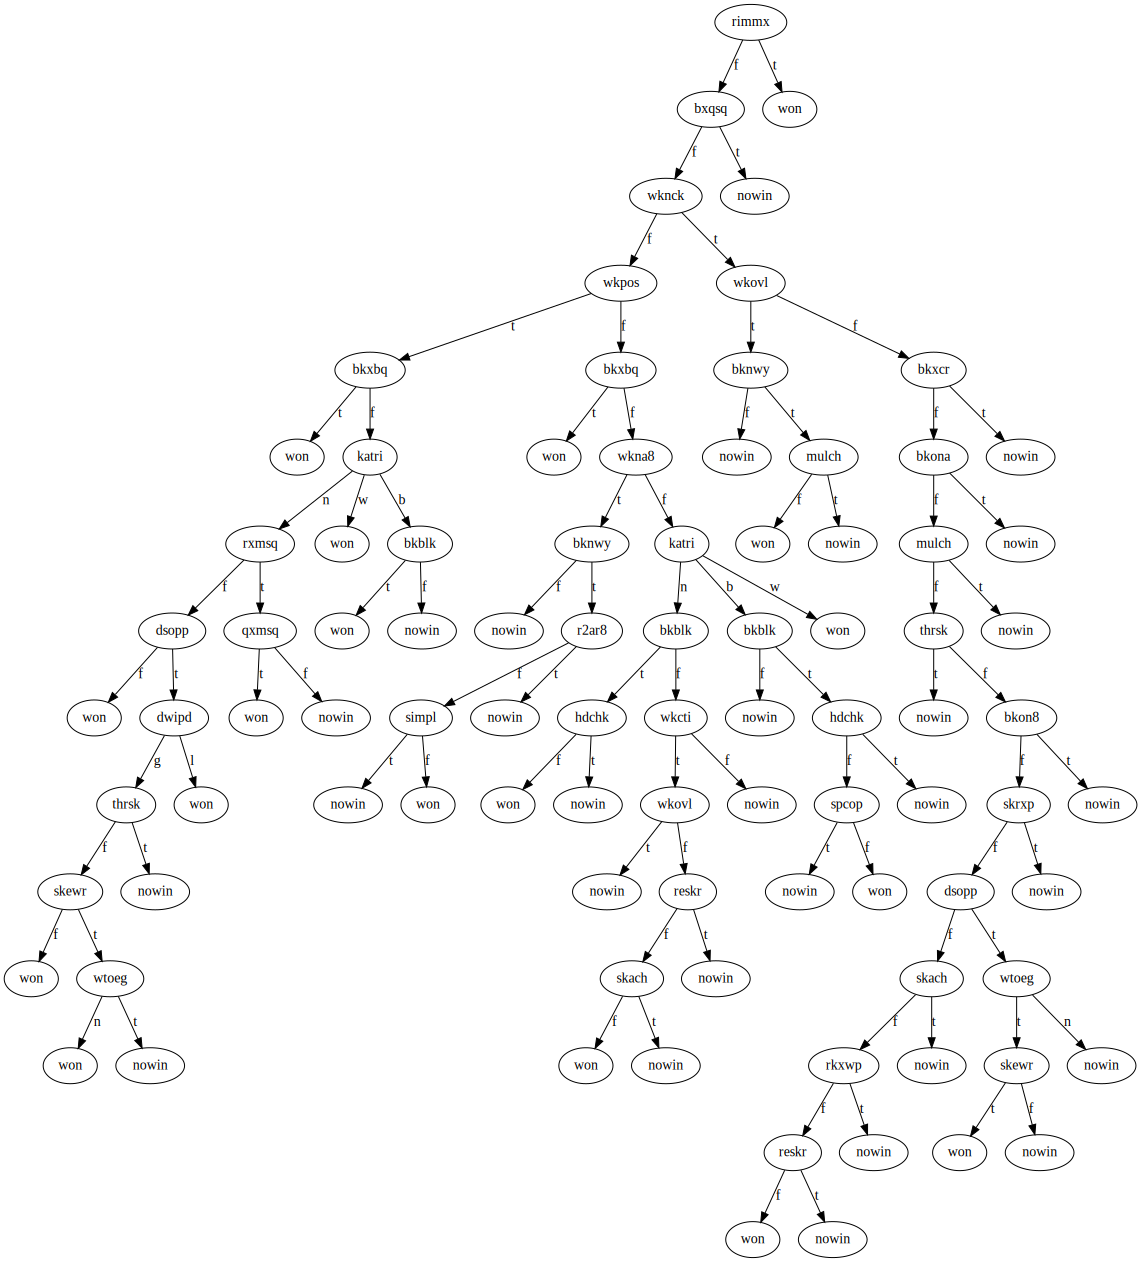

In [88]:
d.getGraph()

##Predicting on Train Dataset

In [89]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


##Predicting on Test Dataset

In [90]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

99.89561586638831

#Baloons Dataset

In [91]:
## Variables ##
dataset='baloons'
split_func='IG'

##Reading Datast

In [92]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [93]:
data

,Color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,ADULT,T
2,YELLOW,SMALL,STRETCH,CHILD,F
3,YELLOW,SMALL,DIP,ADULT,F
4,YELLOW,SMALL,DIP,CHILD,F
5,YELLOW,LARGE,STRETCH,ADULT,T
6,YELLOW,LARGE,STRETCH,ADULT,T
7,YELLOW,LARGE,STRETCH,CHILD,F
8,YELLOW,LARGE,DIP,ADULT,F
9,YELLOW,LARGE,DIP,CHILD,F


In [94]:
data.dtypes

Color       object
size        object
act         object
age         object
inflated    object
dtype: object

In [95]:
# test_df=data
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))


# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

Size of Train Dataset:  14 
 Size of Test Dataset:  6


In [96]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

Color       14
size        14
act         14
age         14
inflated    14
dtype: int64
14


##Descion Tree Training

In [97]:
d=DecisionTree(data,target_name,split_function=split_func)

In [98]:
d.construct()

In [99]:
print(d.tree.no_leafs)

3


In [100]:
d.get_rules()

['act ->  ( STRETCH ) age ->  ( CHILD ) F',
 'act ->  ( STRETCH ) age ->  ( ADULT ) T',
 'act ->  ( DIP ) F']

In [101]:
d.tree.printt()

| act
|----- ( STRETCH) age
|---------- ( CHILD) F
|---------- ( ADULT) T
|----- ( DIP) F


##Graphviz Representation of Decision Tree

In [102]:
f = open("Baloons.dot", "w")
f.write(str(d.getGraph()))
f.close()

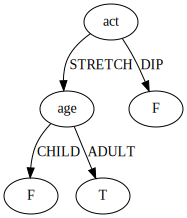

In [103]:
d.getGraph()

##Predicting on Train Dataset

In [104]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


##Predicting on Test Dataset

In [105]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

100.0

#Lymphography Dataset

In [106]:
## Variables ##
dataset='lymphography'
split_func='IG'

##Reading Datast

In [107]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [108]:
data

,class,lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in
0,3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
1,2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
2,3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
4,2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,3,3,2,1,1,2,2,1,2,1,2,2,4,3,5,2,2,2,4
144,2,2,1,1,1,1,1,1,1,1,1,1,1,1,3,1,2,2,1
145,3,2,2,1,1,1,2,1,2,1,3,3,3,3,8,3,2,2,4
146,2,2,1,1,1,1,1,1,2,1,2,2,4,2,2,1,2,2,1


In [109]:
data.dtypes

class              int64
lymphatics         int64
block of affere    int64
bl. of lymph. c    int64
bl. of lymph. s    int64
by pass            int64
extravasates       int64
regeneration of    int64
early uptake in    int64
lym.nodes dimin    int64
lym.nodes enlar    int64
changes in lym     int64
defect in node     int64
changes in node    int64
changes in stru    int64
special forms      int64
dislocation of     int64
exclusion of no    int64
no. of nodes in    int64
dtype: object

In [110]:
# test_df=data
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))


# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

Size of Train Dataset:  104 
 Size of Test Dataset:  44


In [111]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

class              104
lymphatics         104
block of affere    104
bl. of lymph. c    104
bl. of lymph. s    104
by pass            104
extravasates       104
regeneration of    104
early uptake in    104
lym.nodes dimin    104
lym.nodes enlar    104
changes in lym     104
defect in node     104
changes in node    104
changes in stru    104
special forms      104
dislocation of     104
exclusion of no    104
no. of nodes in    104
dtype: int64
104


##Descion Tree Training

In [112]:
d=DecisionTree(data,target_name,split_function=split_func)

In [113]:
d.construct()

In [114]:
print(d.tree.no_leafs)

77


In [115]:
d.get_rules()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


['lym.nodes enlar ->  ( 2 ) changes in stru ->  ( 8 ) lymphatics ->  ( 2 ) exclusion of no ->  ( 1 ) 1',
 'lym.nodes enlar ->  ( 2 ) changes in stru ->  ( 8 ) lymphatics ->  ( 2 ) exclusion of no ->  ( 2 ) dislocation of ->  ( 2 ) changes in node ->  ( 2 ) special forms ->  ( 3 ) early uptake in ->  ( 2 ) 3',
 'lym.nodes enlar ->  ( 2 ) changes in stru ->  ( 8 ) lymphatics ->  ( 2 ) exclusion of no ->  ( 2 ) dislocation of ->  ( 2 ) changes in node ->  ( 2 ) special forms ->  ( 3 ) early uptake in ->  ( 1 ) 1',
 'lym.nodes enlar ->  ( 2 ) changes in stru ->  ( 8 ) lymphatics ->  ( 2 ) exclusion of no ->  ( 2 ) dislocation of ->  ( 2 ) changes in node ->  ( 2 ) special forms ->  ( 2 ) 1',
 'lym.nodes enlar ->  ( 2 ) changes in stru ->  ( 8 ) lymphatics ->  ( 2 ) exclusion of no ->  ( 2 ) dislocation of ->  ( 2 ) changes in node ->  ( 3 ) early uptake in ->  ( 1 ) 3',
 'lym.nodes enlar ->  ( 2 ) changes in stru ->  ( 8 ) lymphatics ->  ( 2 ) exclusion of no ->  ( 2 ) dislocation of ->  (

In [116]:
d.tree.printt()

| lym.nodes enlar
|----- ( 2) changes in stru
|---------- ( 8) lymphatics
|--------------- ( 2) exclusion of no
|-------------------- ( 1) 1
|-------------------- ( 2) dislocation of
|------------------------- ( 2) changes in node
|------------------------------ ( 2) special forms
|----------------------------------- ( 3) early uptake in
|---------------------------------------- ( 2) 3
|---------------------------------------- ( 1) 1
|----------------------------------- ( 2) 1
|------------------------------ ( 3) early uptake in4
|----------------------------------- ( 1) 3
|----------------------------------- ( 2) 2
|------------------------- ( 1) 2
|--------------- ( 3) changes in node8
|-------------------- ( 3) 1
|-------------------- ( 2) 1
|-------------------- ( 4) 3
|--------------- ( 4) 2
|---------- ( 2) lymphatics13
|--------------- ( 3) exclusion of no14
|-------------------- ( 1) 1
|-------------------- ( 2) defect in node
|------------------------- ( 3) 3
|----------------

##Graphviz Representation of Decision Tree

In [117]:
f = open("Lymphography.dot", "w")
f.write(str(d.getGraph()))
f.close()

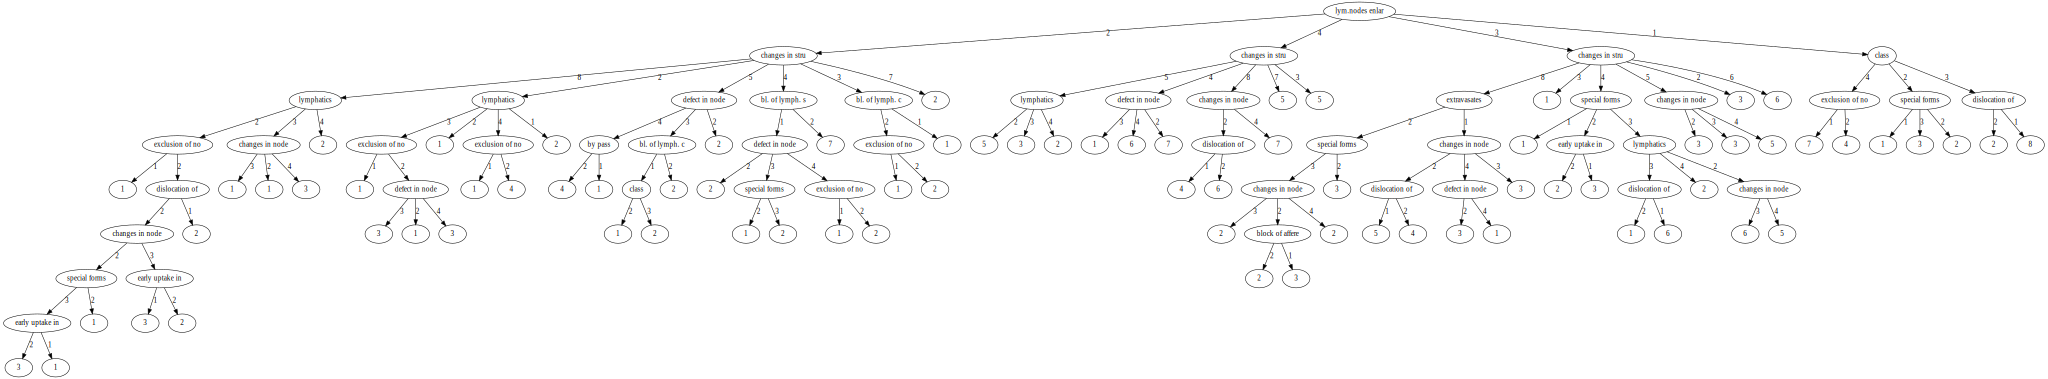

In [118]:
d.getGraph()

##Predicting on Train Dataset

In [119]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


100.0


##Predicting on Test Dataset

In [120]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


75.0

#Heart Dataset

In [121]:
## Variables ##
dataset='heart'
split_func='IG'

##Reading Datast

In [122]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [123]:
data

,diagnosis,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22
0,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,1
2,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76,0,1,0,0,0,1,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
77,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
78,0,0,0,1,1,0,0,1,0,0,...,1,1,0,0,0,0,0,0,1,1


In [124]:
data.dtypes

diagnosis    int64
F1           int64
F2           int64
F3           int64
F4           int64
F5           int64
F6           int64
F7           int64
F8           int64
F9           int64
F10          int64
F11          int64
F12          int64
F13          int64
F14          int64
F15          int64
F16          int64
F17          int64
F18          int64
F19          int64
F20          int64
F21          int64
F22          int64
dtype: object

In [125]:
# test_df=data
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))


# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

Size of Train Dataset:  56 
 Size of Test Dataset:  24


In [126]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

diagnosis    56
F1           56
F2           56
F3           56
F4           56
F5           56
F6           56
F7           56
F8           56
F9           56
F10          56
F11          56
F12          56
F13          56
F14          56
F15          56
F16          56
F17          56
F18          56
F19          56
F20          56
F21          56
F22          56
dtype: int64
56


##Descion Tree Training

In [127]:
d=DecisionTree(data,target_name,split_function=split_func)

In [128]:
d.construct()

In [129]:
print(d.tree.no_leafs)

16


In [130]:
d.get_rules()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


['F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 0 ) F22 ->  ( 0 ) F20 ->  ( 0 ) 0',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 0 ) F22 ->  ( 0 ) F20 ->  ( 1 ) F19 ->  ( 1 ) 0',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 0 ) F22 ->  ( 1 ) F10 ->  ( 0 ) F7 ->  ( 0 ) F20 ->  ( 1 ) 0',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 0 ) F22 ->  ( 1 ) F10 ->  ( 0 ) F7 ->  ( 1 ) 1',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 0 ) F22 ->  ( 1 ) F10 ->  ( 1 ) 0',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 1 ) F5 ->  ( 0 ) F8 ->  ( 1 ) F10 ->  ( 0 ) 1',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 1 ) F5 ->  ( 0 ) F8 ->  ( 1 ) F10 ->  ( 1 ) F22 ->  ( 1 ) 1',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 1 ) F5 ->  ( 0 ) F8 ->  ( 1 ) F10 ->  ( 1 ) F22 ->  ( 0 ) 0',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 1 ) F5 ->  ( 0 ) F8 ->  ( 0 ) 0',
 'F16 ->  ( 0 ) F11 ->  ( 0 ) F13 ->  ( 1 ) F5 ->  ( 1 ) 1',
 'F16 ->  ( 0 ) F11 ->  ( 1 ) F22 ->  ( 0 ) F19 ->  ( 0 ) F10 ->  ( 0 ) F8 ->  ( 0 ) 0',
 'F16 ->  ( 0 ) F11 ->  ( 1 ) F22 ->  ( 0 ) F19 ->

In [131]:
d.tree.printt()

| F16
|----- F11
|---------- F13
|--------------- F22
|-------------------- F20
|------------------------- 0
|------------------------- ( 1) F19
|------------------------------ F21
|----------------------------------- F18
|---------------------------------------- F17
|--------------------------------------------- F15
|-------------------------------------------------- F14
|------------------------------------------------------- F12
|------------------------------------------------------------ F10
|----------------------------------------------------------------- F9
|---------------------------------------------------------------------- F8
|--------------------------------------------------------------------------- F7
|-------------------------------------------------------------------------------- F6
|------------------------------------------------------------------------------------- F5
|------------------------------------------------------------------------------------------ F4
|--

##Graphviz Representation of Decision Tree

In [132]:
f = open("Heart.dot", "w")
f.write(str(d.getGraph()))
f.close()

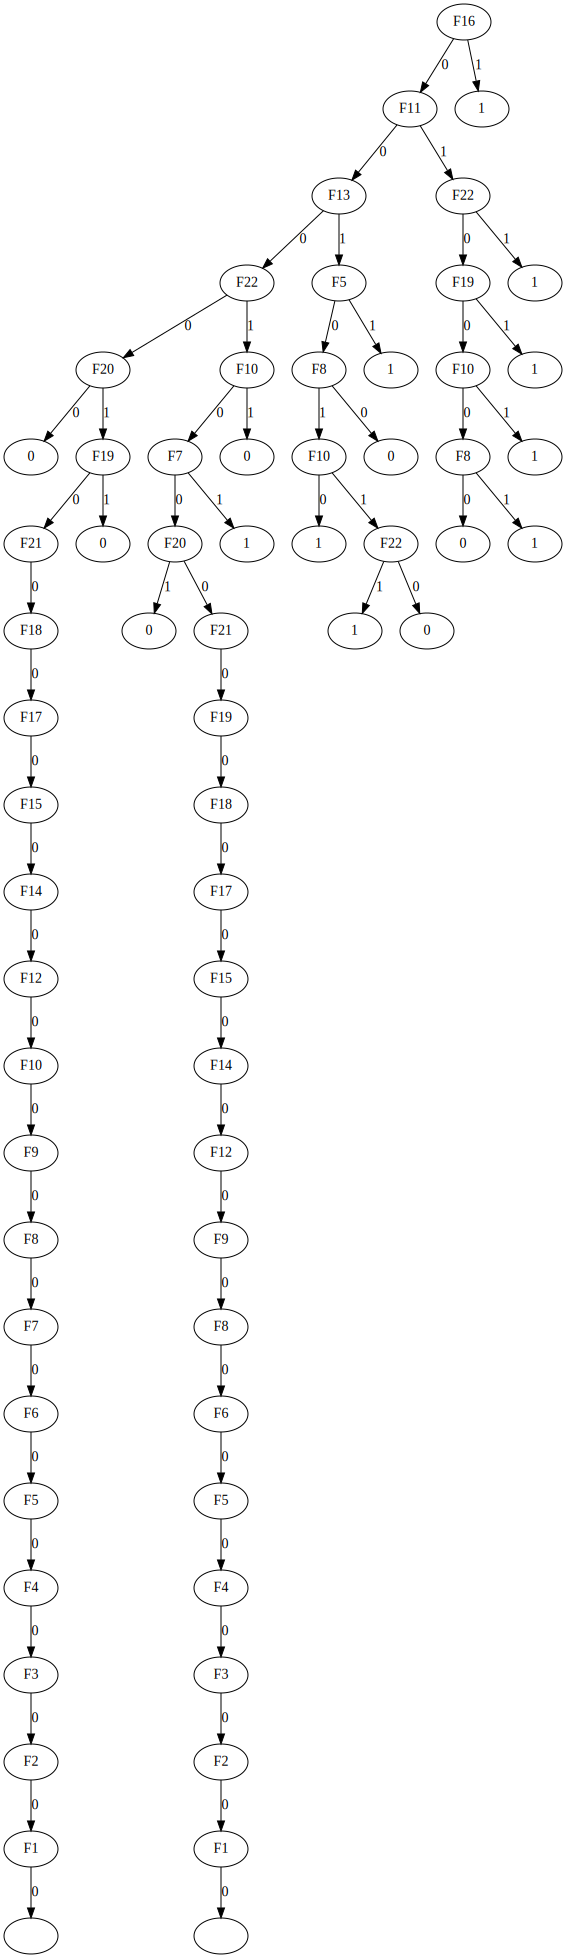

In [133]:
d.getGraph()

##Predicting on Train Dataset

In [134]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

91.07142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


##Predicting on Test Dataset

In [135]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


95.83333333333334